# Extra figures and tables for the report

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
from matplotlib import pyplot as plt, dates as mdates

In [2]:
pd.reset_option('all')
pd.set_option('display.max_columns', None)

In [3]:
# function to plot histogram + boxplot on same axis for x_var
def hist_box_plot(data_series, x_var, title=None, bins='auto', n_samples=None, frac_samples=None):
    data = data_series.sample(n_samples,frac_samples).values
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=data, ax=ax_box)
    sns.histplot(x=data, bins=bins, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_hist.set(xlabel=x_var)
    if title: ax_box.set(title=title)

### Callout-Discharge delay graph

In [472]:
callout = pd.read_pickle('pickle_vars/callout.pkl.xz')

Select only MICU and SICU patients who were discharged (as opposed to discharge cancellation)

In [473]:
callout = callout[callout.CURR_CAREUNIT.isin(['MICU','SICU'])]
callout = callout[callout.CALLOUT_OUTCOME.isin(['Discharged'])]

Calculate delay between callout and discharge

In [474]:
callout['CD_delay'] = callout.apply(lambda row: (row['OUTCOMETIME'] - row['CREATETIME']).total_seconds()/3600,axis=1)

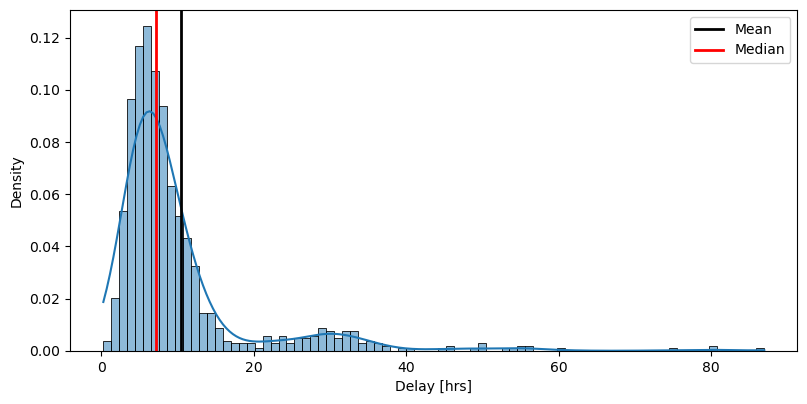

In [475]:
fig, ax = plt.subplots(1, figsize=(8,4))
fig.tight_layout()
data = callout.CD_delay.sample(1000)

sns.histplot(data, kde=True, stat='density', ax=ax)
ax.set(xlabel='Delay [hrs]')

ax.axvline(callout.CD_delay.mean(),linewidth=2, color='k', label='Mean')
ax.axvline(callout.CD_delay.median(),linewidth=2, color='r', label='Median')
ax.legend()

fig.savefig('figures/discharge_delay.png', dpi=500, bbox_inches='tight')

In [85]:
print(callout.CD_delay.mean())
print(callout.CD_delay.median())

10.42675020268974
7.126388888888889


### Time of day graphs

In [110]:
df = pd.read_pickle('pickle_vars/chartevents_for_cohort.pkl.xz')

Get time of day of each measurement (chart event)

In [131]:
TOD = df.CHARTTIME.dt.time
TOD = pd.to_datetime(df.CHARTTIME.dt.time.astype(str))
TOD

/var/folders/vm/ktq2315x1m5gbg84trfh4gz00000gw/T/ipykernel_96518/2338455057.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  TOD = pd.to_datetime(df.CHARTTIME.dt.time.astype(str))


0          2024-03-30 12:00:00
1          2024-03-30 07:09:00
2          2024-03-30 16:00:00
3          2024-03-30 20:00:00
4          2024-03-30 21:00:00
                   ...        
17801590   2024-03-30 23:40:00
17801591   2024-03-30 23:40:00
17801592   2024-03-30 23:40:00
17801593   2024-03-30 23:40:00
17801694   2024-03-30 22:51:00
Name: CHARTTIME, Length: 10837434, dtype: datetime64[ns]

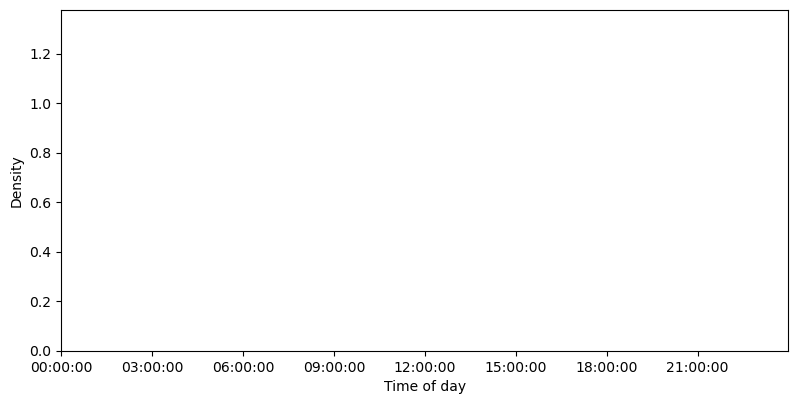

In [132]:
fig, ax = plt.subplots(1, figsize=(8,4))
fig.tight_layout()
data = TOD.sample(n=1000)

sns.histplot(data, kde=True, stat='density', ax=ax)
#data.hist(ax=ax, bins=48)
ax.set(xlabel='Time of day')

#ax.axvline(data.mean(),linewidth=2, color='k', label='Mean')
#ax.axvline(data.median(),linewidth=2, color='r', label='Median')
#ax.legend()
ax.set_xlim([pd.to_datetime('2000-01-01 00:00:00'),
             pd.to_datetime('2000-01-01 23:59:59')])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.savefig('figures/discharge_delay.png', dpi=500)

### Missing data and FM Summary

Import dataframes

In [3]:
FM = pd.read_pickle('pickle_vars/FM_bal_0_resample_days4-8window4-4.pkl.xz')


feat_names = FM.columns.values.tolist()

orig_f = ['bp_MAX', 'bp_MIN', 'bun', 'creatinine', 'gcs_MAX', 'gcs_MIN','haemoglobin', 'hco3', 'hr_MAX',
       'hr_MIN', 'k', 'na', 'pain', 'resp_MAX', 'resp_MIN', 'spo2_MAX', 'spo2_MIN', 
       'temp_MAX', 'temp_MIN', 'airway', 'fio2']

grad_f = [i for i in feat_names if ('GRAD' in i)]

feats = orig_f + grad_f

feats.sort()

In [5]:
miss_feats = ['bp_MIN', 'bp_MAX', 'bp_MEAN_GRAD', 'bp_MIN_MAX_GRAD',
       'bp_MAX_MIN_GRAD', 'gcs_MIN', 'gcs_MAX', 'gcs_MEAN_GRAD',
       'gcs_MIN_MAX_GRAD', 'gcs_MAX_MIN_GRAD', 'hr_MIN', 'hr_MAX',
       'hr_MEAN_GRAD', 'hr_MIN_MAX_GRAD', 'hr_MAX_MIN_GRAD', 'resp_MIN',
       'resp_MAX', 'resp_MEAN_GRAD', 'resp_MIN_MAX_GRAD', 'resp_MAX_MIN_GRAD',
       'spo2_MIN', 'spo2_MAX', 'spo2_MEAN_GRAD', 'spo2_MIN_MAX_GRAD',
       'spo2_MAX_MIN_GRAD', 'temp_MIN', 'temp_MAX', 'temp_MEAN_GRAD',
       'temp_MIN_MAX_GRAD', 'temp_MAX_MIN_GRAD', 'k', 'na', 'bun',
       'creatinine', 'hco3', 'haemoglobin', 'fio2', 'airway', 'pco2', 'po2',
       'pain', 'weight', 'height']

In [6]:
cohort_feats = ['LOS_AC','age','sex','outcome']

In [66]:
miss_summary = dict()
cohort_summary = dict()

HOURS_BEFORE_RFD = 4
HOURS_SINCE_ADM = 4
PREDICT_WHEN = [0, 24, 48, 72, 96]
resample_days = [0,4,5,6,7,8]
for when in PREDICT_WHEN:
    FM = pd.read_pickle('pickle_vars/FM_bal_'+str(when)+'_resample_days'+str(resample_days[1])+'-'+str(resample_days[-1])+'window'+str(HOURS_BEFORE_RFD)+'-'+str(HOURS_SINCE_ADM)+'.pkl.xz')
    
    FM = FM[FM.cohort==1]
    FM_miss_feats = FM[miss_feats]
    miss_summary[str(when)+'hrs'] = FM_miss_feats.isna().sum()/len(FM_miss_feats)
    
    FM_cohort_feats = FM[cohort_feats]
    x = pd.Series()
    x['Total ICU admissions'] = len(FM_cohort_feats)
    x['Age, median years'] = FM_cohort_feats['age'].median()
    x['Sex, % female'] = FM_cohort_feats['sex'].sum()/len(FM_cohort_feats)*100
    x['Length of stay, median days'] = FM_cohort_feats['LOS_AC'].median()
    x['Positive outcome, %'] = FM_cohort_feats['outcome'].sum()/len(FM_cohort_feats)
    cohort_summary[str(when)+'hrs'] = x
    
    

In [68]:
cohort_table = pd.DataFrame.from_dict(cohort_summary)

In [26]:
miss_table = pd.DataFrame.from_dict(miss_summary)


In [8]:
feats_for_tex = ['bp min', 'bp max', 'bp mean grad', 'bp minmax grad',
               'bp maxmin grad', 'gcs min', 'gcs max', 'gcs mean grad',
               'gcs minmax grad', 'gcs maxmin grad', 'hr min', 'hr max',
               'hr mean grad', 'hr minmax grad', 'hr maxmin grad', 'resp min',
               'resp max', 'resp mean grad', 'resp minmax grad', 'resp maxmin grad',
               'spo2 min', 'spo2 max', 'spo2 mean grad', 'spo2 minmax grad',
               'spo2 maxmin grad', 'temp min', 'temp max', 'temp mean grad',
               'temp minmax grad', 'temp maxmin grad', 'k', 'na', 'bun',
               'creatinine', 'hco3', 'haemoglobin', 'fio2', 'airway', 'pco2', 'po2',
               'pain', 'weight', 'height']

In [9]:
mt = pd.DataFrame(miss_table, index=pd.Index(miss_feats, name='Variable'))
mt.rename(index = lambda s: s.replace('_',' '), inplace=True)
mt.to_latex('tex_files/miss_table.tex')

### grad features graph

In [3]:
DATA_PATH = 'pickle_vars/all_data_cleaned.pkl.xz'

In [4]:
df = pd.read_pickle(DATA_PATH)

In [5]:
good_ids = [215353,218606,281515.0,200873.0,209219.0,201682.0,270206.0,281437.0,286676.0,287500.0,264211.0, ]

In [36]:
def plot_stay_visualisation_old(pat, stay, leg_loc=None):
    print('ICU admission ID: '+str(int(stay)))

    pat = df[(df.VARIABLE=='bp') & (df.ICUSTAY_ID==stay) & (df.hrs_SA>=0)& (df.hrs_bRFD>=0)]
    pat = pat.head(50)
    #pat = pat.head(75)
    print('Number of readings: '+str(len(pat)))
    pat = pat[['CHARTTIME','VALUENUM','LOS_AC','hrs_SA','hrs_bRFD']]
    pat = pat.sort_values(by='hrs_SA')

    x='hrs_SA'
    x_max = pat.hrs_SA.max()
    pat_init = pat[pat.hrs_SA<=4]
    pat_init_min = pat_init.loc[[pat_init.VALUENUM.idxmin()]]
    pat_init_max = pat_init.loc[[pat_init.VALUENUM.idxmax()]]

    pat_curr = pat[pat.hrs_SA>=x_max-4]
    pat_curr_min = pat_curr.loc[[pat_curr.VALUENUM.idxmin()]]
    pat_curr_max = pat_curr.loc[[pat_curr.VALUENUM.idxmax()]]

    pat_min_max = pd.concat([pat_init_min, pat_curr_max])
    pat_max_min = pd.concat([pat_init_max, pat_curr_min])

    pat_mean = pd.DataFrame({'hrs_SA': [2, x_max-2], 'VALUENUM': [pat_init.VALUENUM.mean(), pat_curr.VALUENUM.mean()]})

    y='VALUENUM'


    fig, ax = plt.subplots(1)
    #fig.suptitle('Vertically stacked subplots')
    pat.plot(x, y, ax=ax,style="-o", label='All measurement readings')
    pat_mean.plot(x, y, ax=ax,style="-x", color='orange', label='Mean')
    pat_min_max.plot(x, y, ax=ax,style="-x", color='green', label='min-max')
    pat_max_min.plot(x, y, ax=ax,style="-x", color='purple', label='max-min')


    ax.set_ylabel('Blood pressure [mmHg]')
    ax.set_xlabel('Hours since admission')

    #ax.legend(['Blood Pressure'],loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axvspan(0, 4, alpha=0.1, color='red', label='Initial/last 4 hour window')
    ax.axvspan(x_max-4 ,x_max, alpha=0.1, color='red')
    ax.axvline(x=x_max, linestyle='--', color='black', label='Callout')
    
    if leg_loc == None:
        ax.legend(loc='best', bbox_to_anchor=(1, 0.5))
    elif leg_loc == 'outside':
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(loc=leg_loc)
    fig.set_size_inches(9, 4)
    return fig

ICU admission ID: 209219
Number of readings: 29
ICU admission ID: 281437
Number of readings: 36
ICU admission ID: 261951
Number of readings: 22


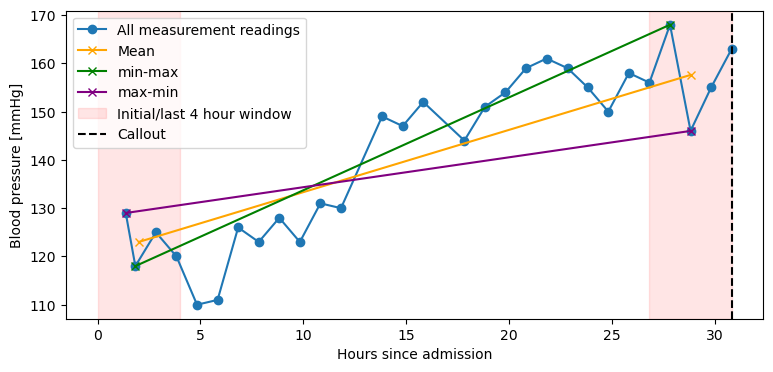

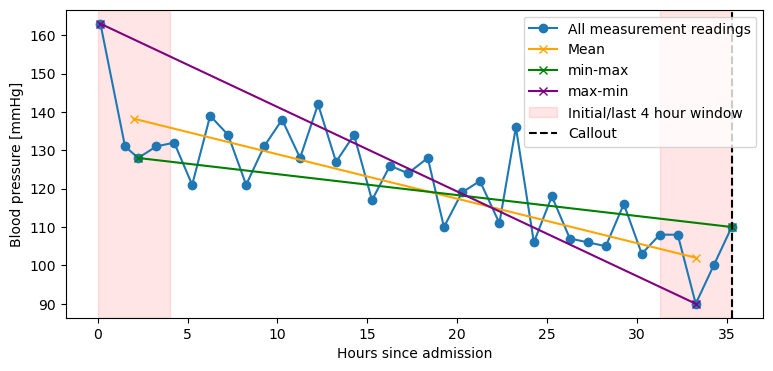

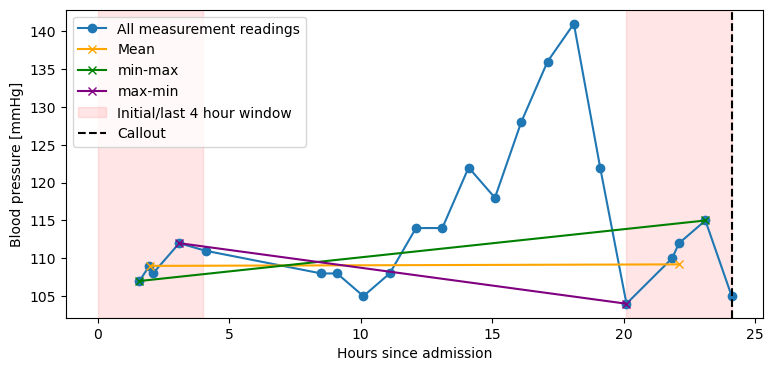

In [37]:
stay = 209219
fig = plot_stay_visualisation_old(df, stay, leg_loc='upper left')
fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

stay = 281437
fig = plot_stay_visualisation_old(df, stay, leg_loc='upper right')
fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

stay = 261951
fig = plot_stay_visualisation_old(df, stay, leg_loc='upper left')
fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

In [420]:
def plot_stay_visualisation(pat, stay, leg_loc=None):
    print('ICU admission ID: '+str(int(stay)))

    pat = df[(df.VARIABLE=='bp') & (df.ICUSTAY_ID==stay) & (df.hrs_SA>=0) & (df.hrs_bRFD>=0)]
    #pat = pat.head(50)
    #pat = pat.head(75)
    print('Number of readings: '+str(len(pat)))
    pat = pat[['CHARTTIME','VALUENUM','LOS_AC','hrs_SA','hrs_bRFD']]
    pat = pat.sort_values(by='hrs_SA')
    
    x='hrs_SA'
    x_max = pat.LOS_AC.values[0]*24
    init_start = (pat['LOS_AC'].values[0]*24 - 4) % 24
    init_end = (pat['LOS_AC'].values[0]*24 - 4) % 24 + 4

    pat_init = pat[(pat['hrs_SA']>=init_start) & (pat['hrs_SA']<=init_end)]

    pat_init_min = pat_init.loc[[pat_init.VALUENUM.idxmin()]]
    pat_init_max = pat_init.loc[[pat_init.VALUENUM.idxmax()]]

    pat_curr = pat[(pat.hrs_SA>=x_max-4) & (pat.hrs_SA<=x_max)]

    pat_curr_min = pat_curr.loc[[pat_curr.VALUENUM.idxmin()]]
    pat_curr_max = pat_curr.loc[[pat_curr.VALUENUM.idxmax()]]

    pat_min_max = pd.concat([pat_init_min, pat_curr_max])
    pat_max_min = pd.concat([pat_init_max, pat_curr_min])

    pat_mean = pd.DataFrame({'hrs_SA': [init_start+2, x_max-2], 'VALUENUM': [pat_init.VALUENUM.mean(), pat_curr.VALUENUM.mean()]})

    y='VALUENUM'


    fig, ax = plt.subplots(1)
    #fig.suptitle('Vertically stacked subplots')
    pat.plot(x, y, ax=ax,style="-o", label='All measurement readings')
    pat_mean.plot(x, y, ax=ax,style="-x", color='orange', label='Mean')
    pat_min_max.plot(x, y, ax=ax,style="-x", color='green', label='min-max')
    pat_max_min.plot(x, y, ax=ax,style="-x", color='purple', label='max-min')


    ax.set_ylabel('Blood pressure [mmHg]')
    ax.set_xlabel('Hours since admission')

    #ax.legend(['Blood Pressure'],loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axvspan(init_start, init_end, alpha=0.1, color='red', label='Initial/last 4 hour window')
    ax.axvspan(x_max-4 ,x_max, alpha=0.1, color='red')
    ax.axvline(x=x_max, linestyle='--', color='black', label='Callout')
    
    if leg_loc == None:
        ax.legend(loc='best', bbox_to_anchor=(1, 0.5))
    elif leg_loc == 'outside':
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend(loc=leg_loc)
    fig.set_size_inches(9, 4)
    return fig

ICU admission ID: 290721
Number of readings: 61
ICU admission ID: 281437
Number of readings: 36
ICU admission ID: 231356
Number of readings: 70


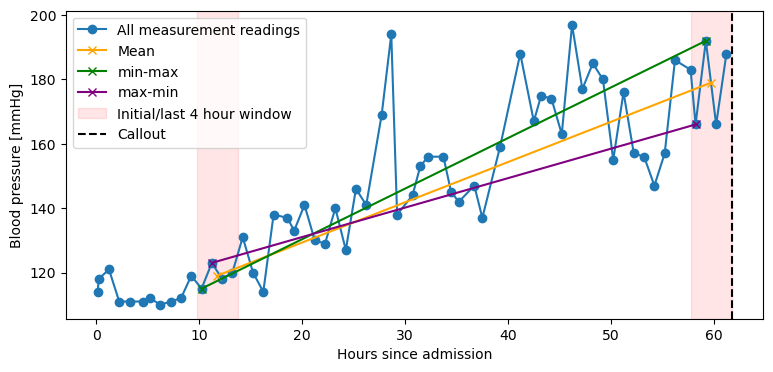

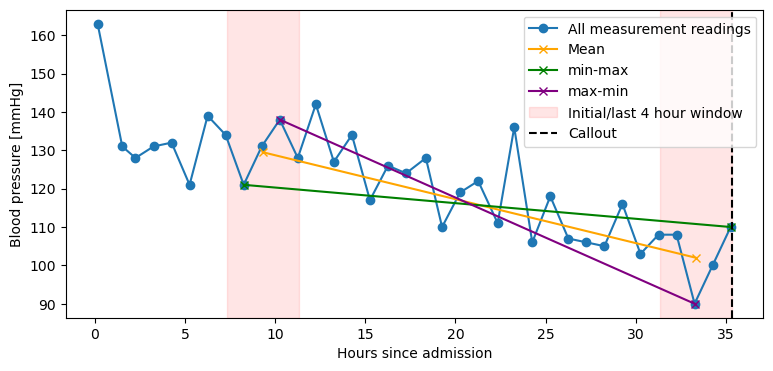

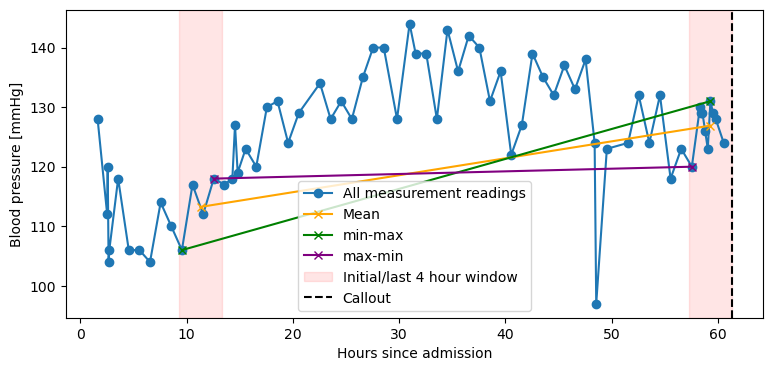

In [426]:
#stay = 209219
#fig = plot_stay_visualisation(df, stay, leg_loc='upper left')
#fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

stay = 290721
fig = plot_stay_visualisation(df, stay, leg_loc='upper left')
fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

stay = 281437
fig = plot_stay_visualisation(df, stay, leg_loc='upper right')
fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

stay = 231356
fig = plot_stay_visualisation(df, stay, leg_loc='lower center')
fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

#stay = 218768
#fig = plot_stay_visualisation(df, stay, leg_loc='upper left')
#fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

In [349]:
df2 = df[df.LOS_AC.between(1.15,4)]

ICU admission ID: 265585
Number of readings: 35


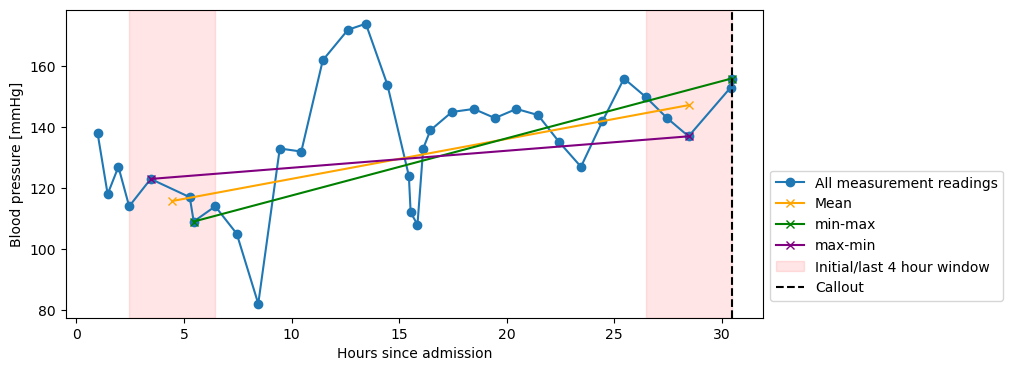

In [413]:
random_stay = df2.ICUSTAY_ID.sample(n=1)
random_stay = random_stay.values[0]
fig = plot_stay_visualisation(df2, random_stay)

In [414]:
good_ids=[286013, 290721, 283341, 257538, 286756, 218768, 221881, 273682, 252867,271288, 231356]

ICU admission ID: 286013
Number of readings: 31
ICU admission ID: 290721
Number of readings: 61
ICU admission ID: 283341
Number of readings: 24
ICU admission ID: 257538
Number of readings: 58
ICU admission ID: 286756
Number of readings: 37
ICU admission ID: 218768
Number of readings: 42
ICU admission ID: 221881
Number of readings: 56
ICU admission ID: 273682
Number of readings: 31
ICU admission ID: 252867
Number of readings: 56
ICU admission ID: 271288
Number of readings: 75
ICU admission ID: 231356
Number of readings: 70


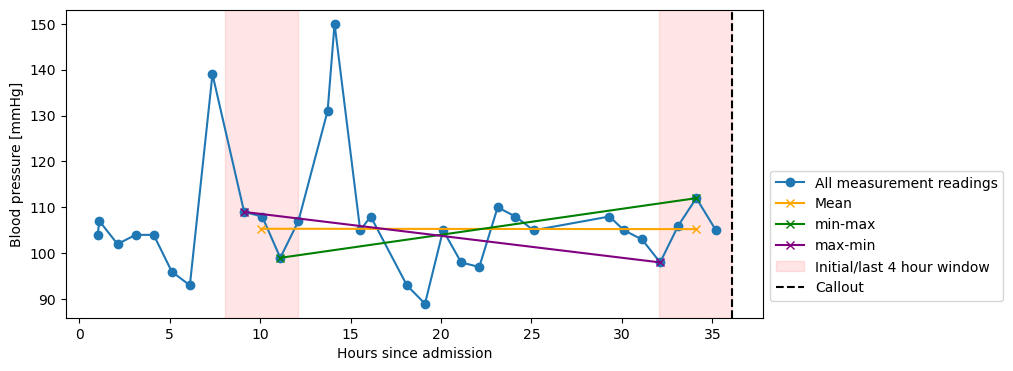

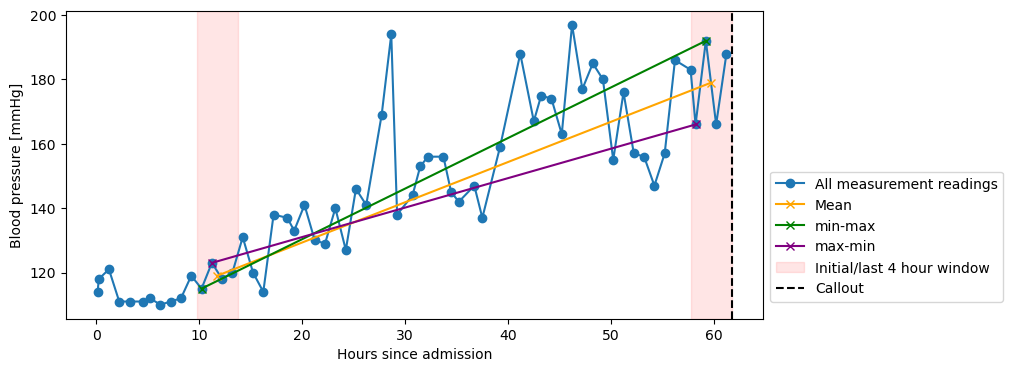

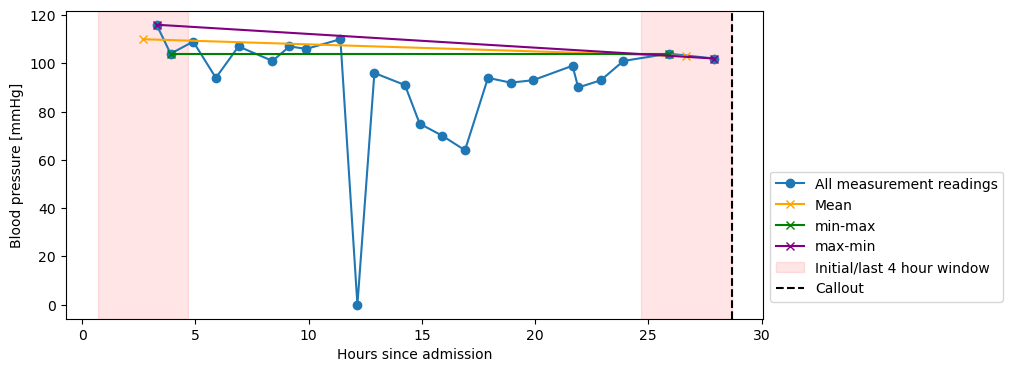

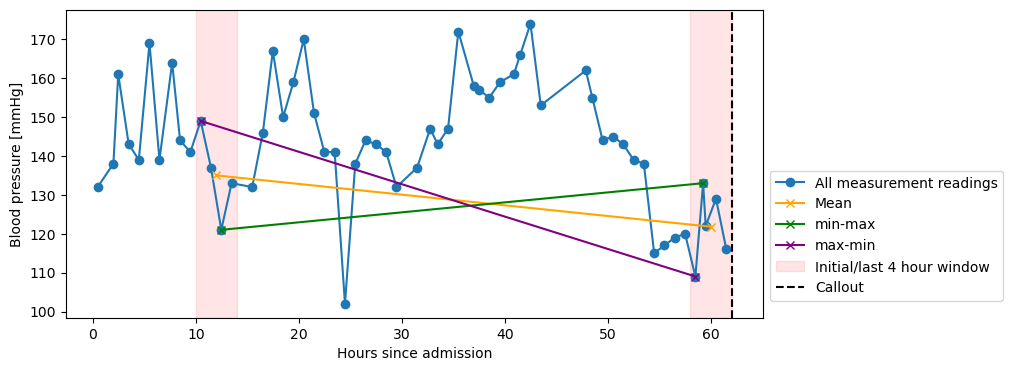

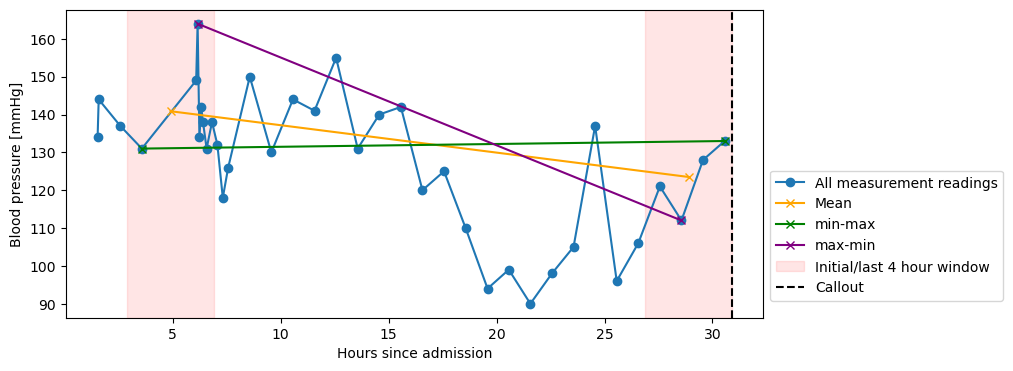

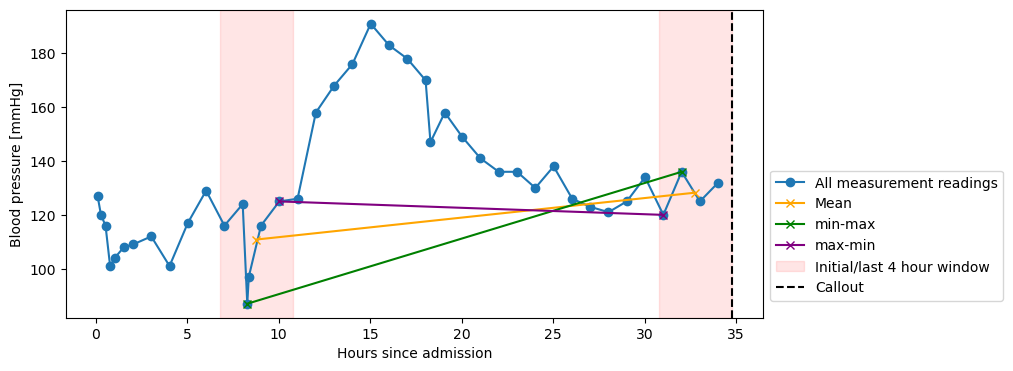

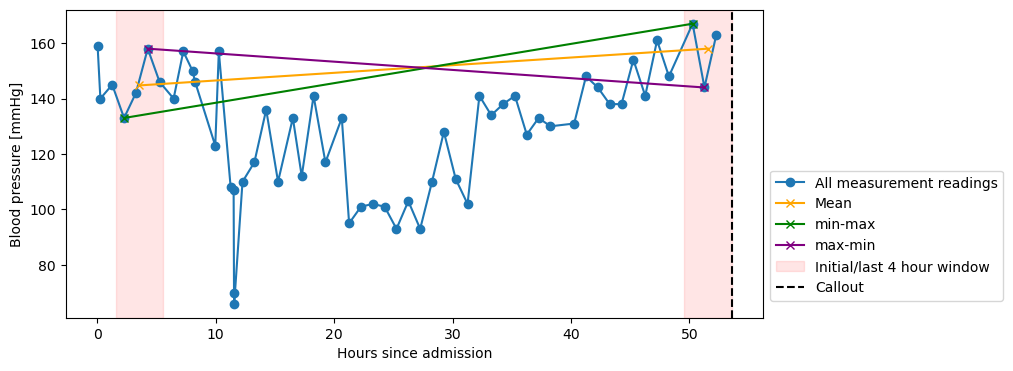

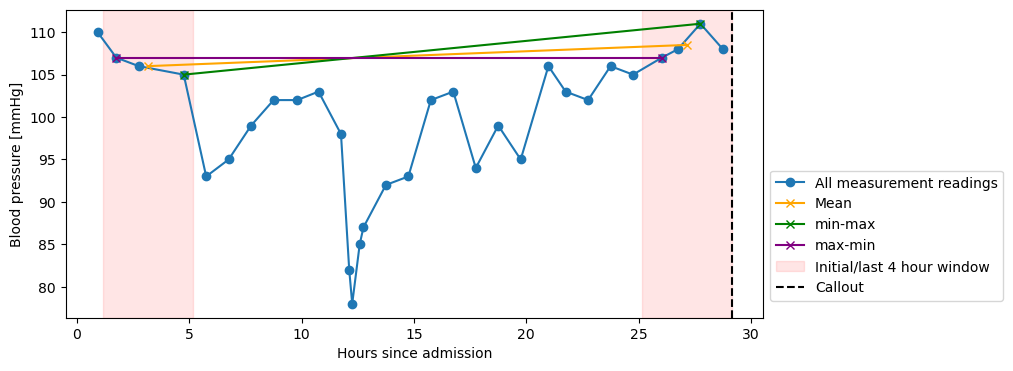

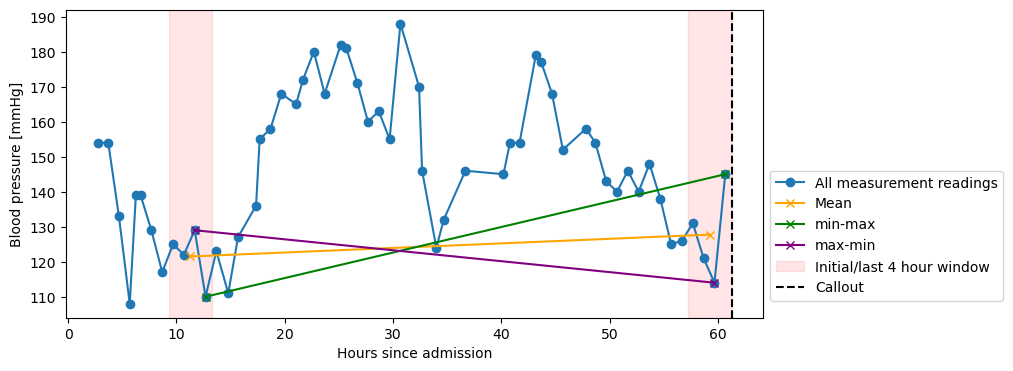

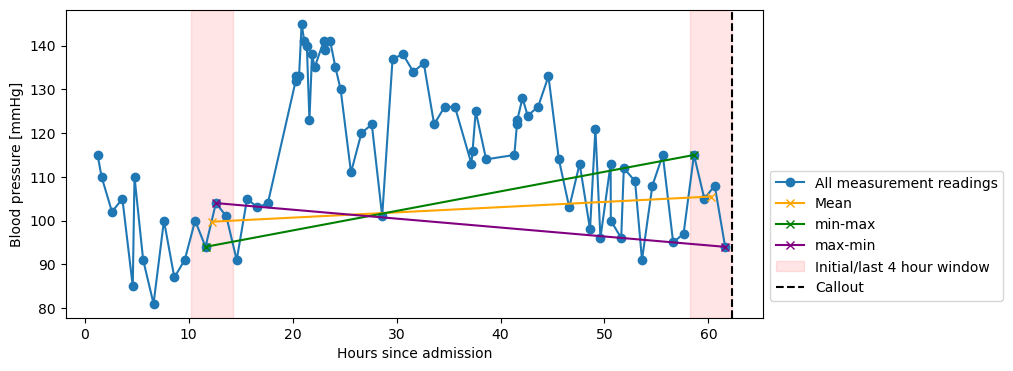

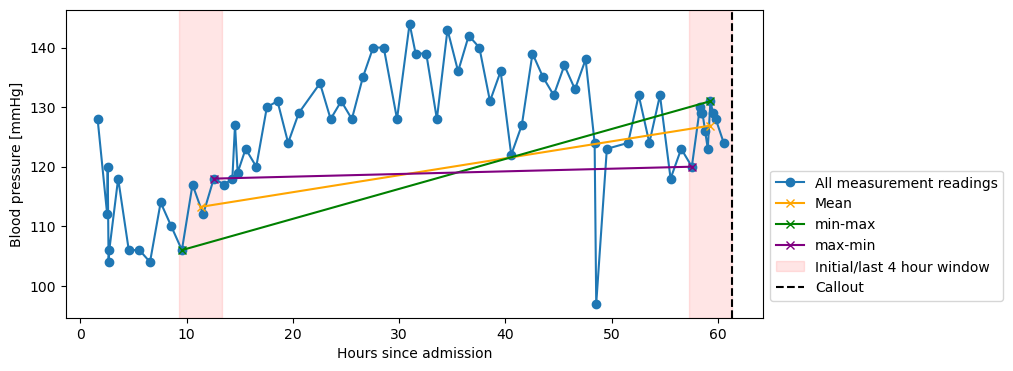

In [416]:
#random_stay_id = df.ICUSTAY_ID.sample(n=1)
for stay in good_ids:
    fig = plot_stay_visualisation(df,stay,leg_loc=None)
    #fig.savefig('figures/stay_vis_ID_'+str(int(stay))+'.png', dpi=500,bbox_inches = "tight")

In [412]:
good_ids.append(stay)
good_ids

[215353,
 218606,
 281515.0,
 200873.0,
 209219.0,
 201682.0,
 270206.0,
 281437.0,
 286676.0,
 287500.0,
 264211.0]

### EBM results

In [92]:
PREDICT_HOURS = [0,24,48,72,96]
results_tab = dict()
mod_comp = dict()
for when in PREDICT_HOURS:
    x = pd.Series()
    
    y = pd.Series()

    ebm_results = pd.read_pickle('results/ebm_'+str(when)+'_results.pickle')
    metrics = ['f1','accuracy','sensitivity','pauc','specificity']
    
    for metric in metrics:
        scores = ebm_results['performance_mimic'][metric]['0.30']  
        x[metric] = "%.4f (%.4f)" %(np.mean(scores),(np.std(scores)))
        y[metric] = np.mean(scores)

    x['auc'] = "%.4f (%.4f)" %(np.mean(ebm_results['performance_mimic']['auc']),np.std(ebm_results['performance_mimic']['auc']))
    x['brier'] = "%.4f (%.4f)" %(np.mean(ebm_results['performance_mimic']['brier']),np.std(ebm_results['performance_mimic']['brier']))
    
    y['auc'] = np.mean(ebm_results['performance_mimic']['auc'])
    y['brier'] = np.mean(ebm_results['performance_mimic']['brier'])
    results_tab[when] = x
    mod_comp[when] = y

results_table = pd.DataFrame.from_dict(results_tab)
results_table.to_latex('tex_files/ebm_results_table.tex')
results_table

,0,24,48,72,96
f1,0.8262 (0.0107),0.7666 (0.0062),0.7031 (0.0181),0.6447 (0.0265),0.5870 (0.0315)
accuracy,0.8072 (0.0095),0.7538 (0.0057),0.7024 (0.0137),0.6581 (0.0187),0.6179 (0.0220)
sensitivity,0.9157 (0.0175),0.8104 (0.0127),0.7079 (0.0268),0.6199 (0.0366),0.5425 (0.0437)
pauc,0.1881 (0.0085),0.1548 (0.0050),0.1341 (0.0068),0.1165 (0.0083),0.0975 (0.0078)
specificity,0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000)
auc,0.8779 (0.0102),0.8249 (0.0074),0.7717 (0.0124),0.7277 (0.0112),0.6756 (0.0191)
brier,0.1359 (0.0056),0.1680 (0.0032),0.1949 (0.0046),0.2115 (0.0033),0.2265 (0.0047)


Now plot a graph of how metrics change for each model

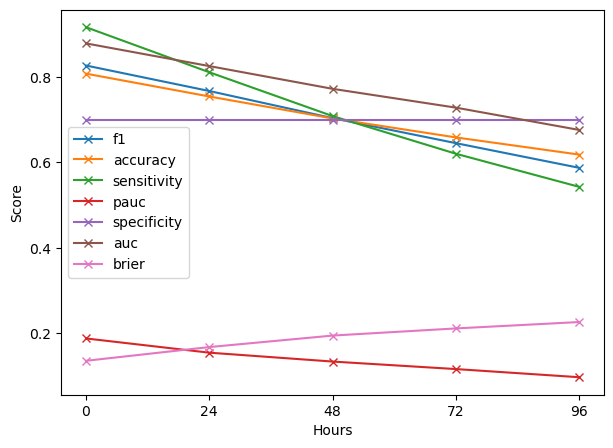

In [93]:
mod_comp_table = pd.DataFrame.from_dict(mod_comp).T
fig, ax =plt.subplots(1)
mod_comp_table.plot(ax=ax,xticks=[0,24,48,72,96],style='x-')
ax.set_xlabel('Hours')
ax.set_ylabel('Score')
fig.set_size_inches(7, 5)
fig.savefig('figures/ebm_model_comp.png', dpi=500,bbox_inches = "tight")

**Complete case**

In [96]:
PREDICT_HOURS = [0,24,48,72,96]
results_tab = dict()
mod_comp = dict()
for when in PREDICT_HOURS:
    x = pd.Series()
    
    y = pd.Series()

    ebm_results = pd.read_pickle('results/ebm_CC_'+str(when)+'_results.pickle')
    metrics = ['f1','accuracy','sensitivity','pauc','specificity']
    
    for metric in metrics:
        scores = ebm_results['performance_mimic'][metric]['0.30']  
        x[metric] = "%.4f (%.4f)" %(np.mean(scores),(np.std(scores)))
        y[metric] = np.mean(scores)

    x['auc'] = "%.4f (%.4f)" %(np.mean(ebm_results['performance_mimic']['auc']),np.std(ebm_results['performance_mimic']['auc']))
    x['brier'] = "%.4f (%.4f)" %(np.mean(ebm_results['performance_mimic']['brier']),np.std(ebm_results['performance_mimic']['brier']))
    
    y['auc'] = np.mean(ebm_results['performance_mimic']['auc'])
    y['brier'] = np.mean(ebm_results['performance_mimic']['brier'])
    results_tab[when] = x
    mod_comp[when] = y

results_table = pd.DataFrame.from_dict(results_tab)
results_table.to_latex('tex_files/ebm_CC_results_table.tex')
results_table

,0,24,48,72,96
f1,0.8401 (0.0151),0.7451 (0.0246),0.6339 (0.0187),0.5647 (0.0421),0.5726 (0.0482)
accuracy,0.8160 (0.0182),0.7347 (0.0172),0.6499 (0.0120),0.6070 (0.0312),0.6075 (0.0276)
sensitivity,0.9578 (0.0086),0.7743 (0.0306),0.6130 (0.0237),0.5241 (0.0610),0.5303 (0.0604)
pauc,0.2266 (0.0096),0.1588 (0.0145),0.1152 (0.0100),0.0860 (0.0136),0.0919 (0.0108)
specificity,0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000)
auc,0.9181 (0.0104),0.8175 (0.0191),0.7230 (0.0188),0.6545 (0.0306),0.6562 (0.0261)
brier,0.1088 (0.0075),0.1749 (0.0088),0.2137 (0.0051),0.2340 (0.0068),0.2328 (0.0067)


Now plot a graph of how metrics change for each model

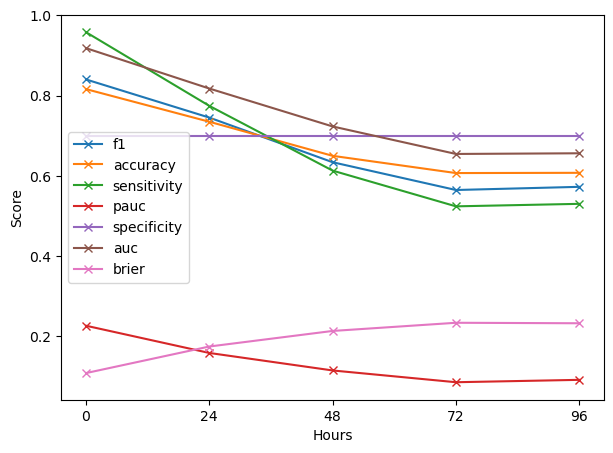

In [97]:
mod_comp_table = pd.DataFrame.from_dict(mod_comp).T
fig, ax =plt.subplots(1)
mod_comp_table.plot(ax=ax,xticks=[0,24,48,72,96],style='x-')
ax.set_xlabel('Hours')
ax.set_ylabel('Score')
fig.set_size_inches(7, 5)
fig.savefig('figures/ebm_CC_model_comp.png', dpi=500,bbox_inches = "tight")

### Random Forest results


In [94]:
PREDICT_HOURS = [0,24,48,72,96]
results_tab = dict()
mod_comp = dict()
for when in PREDICT_HOURS:
    x = pd.Series()
    
    y = pd.Series()

    rf_results = pd.read_pickle('results/rf_'+str(when)+'_results.pickle')
    metrics = ['f1','accuracy','sensitivity','pauc','specificity']
    
    for metric in metrics:
        scores = rf_results['performance_mimic'][metric]['0.30']  
        x[metric] = "%.4f (%.4f)" %(np.mean(scores),(np.std(scores)))
        y[metric] = np.mean(scores)

    x['auc'] = "%.4f (%.4f)" %(np.mean(rf_results['performance_mimic']['auc']),np.std(rf_results['performance_mimic']['auc']))
    x['brier'] = "%.4f (%.4f)" %(np.mean(rf_results['performance_mimic']['brier']),np.std(rf_results['performance_mimic']['brier']))
    
    y['auc'] = np.mean(rf_results['performance_mimic']['auc'])
    y['brier'] = np.mean(rf_results['performance_mimic']['brier'])
    results_tab[when] = x
    mod_comp[when] = y

results_table = pd.DataFrame.from_dict(results_tab)
results_table.to_latex('tex_files/rf_results_table.tex')
results_table

,0,24,48,72,96
f1,0.8364 (0.0054),0.7473 (0.0104),0.6548 (0.0154),0.5678 (0.0197),0.5181 (0.0156)
accuracy,0.8048 (0.0058),0.7464 (0.0076),0.6993 (0.0086),0.6628 (0.0094),0.6483 (0.0094)
sensitivity,0.8872 (0.0107),0.8003 (0.0166),0.7010 (0.0208),0.6019 (0.0263),0.5570 (0.0219)
pauc,0.1786 (0.0025),0.1531 (0.0040),0.1363 (0.0043),0.1162 (0.0059),0.1002 (0.0043)
specificity,0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000)
auc,0.8650 (0.0028),0.8179 (0.0068),0.7761 (0.0041),0.7146 (0.0158),0.6807 (0.0124)
brier,0.1400 (0.0017),0.1734 (0.0032),0.1893 (0.0018),0.2022 (0.0043),0.2037 (0.0045)


Now plot a graph of how metrics change for each model

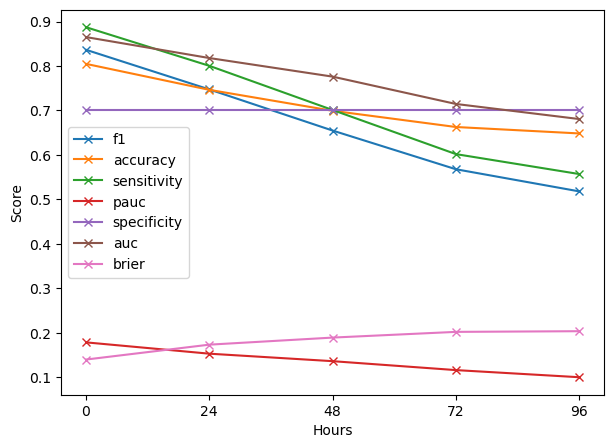

In [95]:
mod_comp_table = pd.DataFrame.from_dict(mod_comp).T
fig, ax =plt.subplots(1)
mod_comp_table.plot(ax=ax,xticks=[0,24,48,72,96],style='x-')
ax.set_xlabel('Hours')
ax.set_ylabel('Score')
fig.set_size_inches(7, 5)
fig.savefig('figures/rf_model_comp.png', dpi=500,bbox_inches = "tight")

**Complete case**

In [98]:
PREDICT_HOURS = [0,24,48,72,96]
results_tab = dict()
mod_comp = dict()
for when in PREDICT_HOURS:
    x = pd.Series()
    
    y = pd.Series()

    rf_results = pd.read_pickle('results/rf_CC_'+str(when)+'_results.pickle')
    metrics = ['f1','accuracy','sensitivity','pauc','specificity']
    
    for metric in metrics:
        scores = rf_results['performance_mimic'][metric]['0.30']  
        x[metric] = "%.4f (%.4f)" %(np.mean(scores),(np.std(scores)))
        y[metric] = np.mean(scores)

    x['auc'] = "%.4f (%.4f)" %(np.mean(rf_results['performance_mimic']['auc']),np.std(rf_results['performance_mimic']['auc']))
    x['brier'] = "%.4f (%.4f)" %(np.mean(rf_results['performance_mimic']['brier']),np.std(rf_results['performance_mimic']['brier']))
    
    y['auc'] = np.mean(rf_results['performance_mimic']['auc'])
    y['brier'] = np.mean(rf_results['performance_mimic']['brier'])
    results_tab[when] = x
    mod_comp[when] = y

results_table = pd.DataFrame.from_dict(results_tab)
results_table.to_latex('tex_files/rf_CC_results_table.tex')
results_table

,0,24,48,72,96
f1,0.8371 (0.0112),0.7499 (0.0237),0.6247 (0.0384),0.5712 (0.0326),0.5362 (0.0570)
accuracy,0.8160 (0.0094),0.7380 (0.0195),0.6460 (0.0233),0.6099 (0.0234),0.5873 (0.0292)
sensitivity,0.9384 (0.0157),0.7841 (0.0369),0.5979 (0.0486),0.5326 (0.0440),0.4819 (0.0640)
pauc,0.2182 (0.0100),0.1569 (0.0135),0.1120 (0.0069),0.0978 (0.0067),0.0865 (0.0146)
specificity,0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000),0.7000 (0.0000)
auc,0.9060 (0.0122),0.8075 (0.0208),0.7106 (0.0248),0.6582 (0.0258),0.6453 (0.0256)
brier,0.1203 (0.0092),0.1803 (0.0100),0.2182 (0.0078),0.2326 (0.0081),0.2359 (0.0066)


Now plot a graph of how metrics change for each model

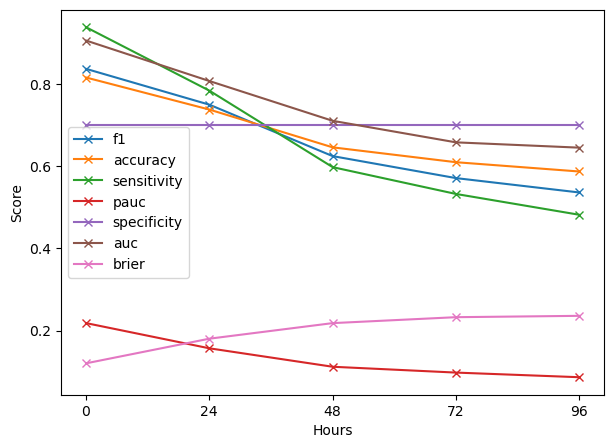

In [99]:
mod_comp_table = pd.DataFrame.from_dict(mod_comp).T
fig, ax =plt.subplots(1)
mod_comp_table.plot(ax=ax,xticks=[0,24,48,72,96],style='x-')
ax.set_xlabel('Hours')
ax.set_ylabel('Score')
fig.set_size_inches(7, 5)
fig.savefig('figures/rf_CC_model_comp.png', dpi=500,bbox_inches = "tight")

### next thing